In [1]:
import pandas as pd
import numpy as np

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

# Data generation example: figure 3 page 13

samples = tfp.mcmc.sample_halton_sequence(2,num_results=200,seed=127)
samples = samples.numpy()
samples[:,0] = samples[:,0]*40 +30
samples[:,1] = samples[:,1]*0.38-0.01
plt.scatter(samples[:,0],samples[:,1])
plt.xlabel('S')
plt.ylabel('t')
plt.show()

In [2]:
#Black Scholes pricing formula (from: https://aaronschlegel.me/black-scholes-formula-python.html)
import scipy.stats as si
def euro_call(S, K, T, r, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call
def delta_call(S, K, T, r, sigma):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    delta_call = si.norm.cdf(d1, 0.0, 1.0)
    
    return delta_call
def theta_call(S, K, T, r, sigma):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    prob_density = 1 / np.sqrt(2 * np.pi) * np.exp(-d1 ** 2 * 0.5)
    
    theta = (-sigma * S * prob_density) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    
    return theta

In [3]:
# Illustration from section 2.5

#Parameters and data
r = 0.04
sigma = 0.22
T = 0.4 
K = 50

stock = np.linspace(32,68,10,dtype=np.float64)
tau = np.linspace(0.04,0.4,10,dtype= np.float64)

grid = [(t,s) for t in tau for s in stock]
grid = np.asarray(grid)

prices = euro_call(grid[:,1],K,grid[:,0],r,sigma)
deltas = delta_call(grid[:,1],K,grid[:,0],r,sigma)

df_train = pd.DataFrame(data=[grid[:,0],grid[:,1],prices,deltas]).T
df_train.columns=['Tau','Stock','Price','Delta']

X = np.array(df_train.iloc[:,:2])
y = np.array(df_train.iloc[:,2])

In [ ]:
df_train[(np.abs(df_train['Tau']-0.2)<0.001)]

In [4]:
# Attempt 3: tensorflow implementation

import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

#Define hyperparameters
process_variance = 1
noise_variance = 0.0001
length_scales = [1,1]

sp = tf.Variable(process_variance,dtype=tf.float64, name = 'sigma_proc')
#sn2 = tfp.util.TransformedVariable(0.01,bijector = tfb.Square(),dtype=tf.float64 , name = 'sigma_noise2')
sn2 = tf.Variable(noise_variance,dtype=tf.float64,name = 'sigma_noise2',constraint= lambda x: x**2)
scales = tfp.util.TransformedVariable(length_scales,tfb.Identity(),dtype=tf.float64 ,name = 'length_scales')
scales = tf.Variable(length_scales,dtype=tf.float64 ,name = 'length_scales')


#Define kernel

class CustomSE(psd_kernels.PositiveSemidefiniteKernel):
    def __init__(self,feature_ndims=1, parameters=None,dtype=None, name=None, validate_args=False):
        super().__init__(feature_ndims, dtype, name, validate_args, parameters)
        self.amplitude = parameters['amp']
        self.length_scales = parameters['scales']
        self.family = parameters['family']
    def _apply(self,x,y,example_ndims):
        scaled_diff = tf.math.abs(x-y)/self.length_scales
        if (self.family == 'M52'): return self._apply_M52(scaled_diff)
        if (self.family == 'M32'): return self._apply_M32(scaled_diff)
        return self._apply_SE(scaled_diff)
    
    def _apply_SE(self,diff):
        return self.amplitude*tf.math.exp(-tf.math.reduce_sum(diff**2/2,axis=-1))
    
    def _apply_M52(self,diff):
        prod_element = (1+np.sqrt(5)*diff+5*(diff**2)/3)*tf.math.exp(-np.sqrt(5)*diff)
        return self.amplitude*tf.reduce_prod(prod_element,axis=-1)
        
    def _apply_M32(self,diff):
        prod_element = (1+np.sqrt(3)*diff)*tf.math.exp(-np.sqrt(3)*diff)
        return self.amplitude*tf.reduce_prod(prod_element,axis=-1)
    
    def _batch_shape(self):
        scalar_shape = tf.TensorShape([])
        return scalar_shape

    def _batch_shape_tensor(self):
        return tf.convert_to_tensor(self.batch_shape, dtype=tf.int32, name='batch_shape')

kernel_family = 'SE' #'M32' 'M52'
def base_kernel(family = 'SE'):
    if (family == 'M52'): return psd_kernels.MaternFiveHalves(amplitude = sp)
    if (family == 'M32'): return psd_kernels.MaternThreeHalves(amplitude =sp)
    return psd_kernels.ExponentiatedQuadratic(amplitude = sp)

kernel = psd_kernels.FeatureScaled(base_kernel(kernel_family),scales)
my_kernel = CustomSE(1,parameters ={'amp' : sp , 'scales': scales,'family' : kernel_family})

#Load data
X = np.array(df_train.iloc[:,:2])
y = np.array(df_train.iloc[:,2])

b_0 = tf.Variable(0,dtype=tf.float64, name = 'b0')
b_1 = tf.Variable(1,dtype=tf.float64, name = 'b1')
b = tf.Variable([[1,1]],dtype=tf.float64, name= 'b12')

#Define mean function
def mean_f(x): return tf.squeeze(b_0 + tf.linalg.matmul(x, b, transpose_b=True))
#def mean_f(x): return tf.squeeze(b_0+b_1*x[:,-1])

X_tf = tf.constant(X)

GP = tfp.distributions.GaussianProcess(my_kernel, index_points=X_tf, mean_fn=mean_f, observation_noise_variance=sn2,jitter=1e-06, name='GP')

for var in GP.trainable_variables: print(var)

<tf.Variable 'sigma_noise2:0' shape=() dtype=float64, numpy=0.0001>
<tf.Variable 'sigma_proc:0' shape=() dtype=float64, numpy=1.0>
<tf.Variable 'length_scales:0' shape=(2,) dtype=float64, numpy=array([1., 1.])>


In [ ]:
# Define optimizer and perform gradient steps
optimizer = tf.optimizers.Adam(learning_rate=0.001)

@tf.function
def optimize():
    with tf.GradientTape() as tape:
        loss = -GP.log_prob(y)
    hyperparam = GP.trainable_variables + (b_0,b)
    grads = tape.gradient(loss, hyperparam)
    optimizer.apply_gradients(zip(grads, hyperparam))
    return loss

for i in range(30000):
    neg_log_likelihood = optimize()
    if i % 2000 == 0:
        print("Step {}: NLL = {}".format(i, neg_log_likelihood))
print("Final NLL = {}".format(neg_log_likelihood))

print(GP.trainable_variables)
print(b_0,b)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Step 0: NLL = 14566.254740520686
Step 2000: NLL = -157.51092201176414
Step 4000: NLL = -182.19492338893951


In [54]:
test_stocks = np.linspace(34,62,8)
#test_stocks = stock-2
X_02 = np.zeros([len(test_stocks),2])
X_02[:,0] = 0.2
X_02[:,1]= test_stocks
y_02 = euro_call(test_stocks,K,X_02[:,0],r,sigma)
deltas_02 = delta_call(test_stocks,K,X_02[:,0],r,sigma)

In [48]:
data_02 = df_train[np.abs(df_train['Tau']-0.2)<0.01].values
X_02 = data_02[:,:2]
y_02 = data_02[:,2]
deltas_02 = data_02[:,3]

In [59]:
# Define regression model with updated parameters and make prediction
from scipy.stats import norm
confidence = 0.95
z = norm.ppf((confidence+1)/2)
GPR = tfp.distributions.GaussianProcessRegressionModel(my_kernel, index_points=tf.constant(X_02,dtype=tf.float64),observation_index_points=X_tf,observations = y, mean_fn=mean_f, \
                                        observation_noise_variance=sn2,jitter=1e-06, name='GPR')
pred_price = GPR.mean()

lower_bound = pred_price - z*np.sqrt(GPR.variance())
upper_bound = pred_price + z*np.sqrt(GPR.variance())

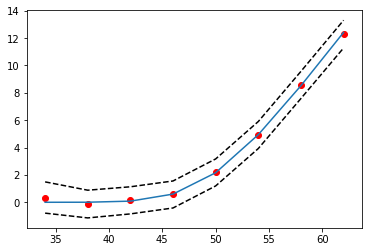

0.020537543964990638


In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

plt.plot(test_stocks,y_02)
plt.scatter(test_stocks,pred_price,color='red')
plt.plot(test_stocks,upper_bound,'--',color='black')
plt.plot(test_stocks,lower_bound,'--',color='black')
plt.show()
print(mse(pred_price,y_02))

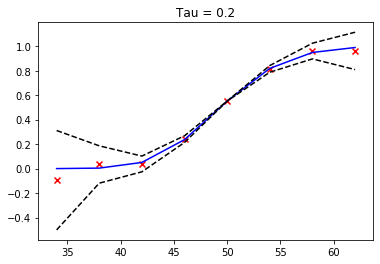

0.001375060943418707


In [61]:
#In-sample verification
x_test = tf.Variable(X_02,dtype=tf.float64)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape1:
        GPR = tfp.distributions.GaussianProcessRegressionModel(my_kernel, index_points=x_test,observation_index_points=X_tf,observations = y, mean_fn=mean_f, \
                                            observation_noise_variance=sn2,jitter=1e-06, name='GPR')
        p_hat = GPR.mean()
        K_star = GPR.variance()
        
delta_ = tape1.gradient(p_hat,x_test)
K_g = tape2.gradient(K_star,x_test)

lower_bound = delta_[:,1]-z*np.sqrt(np.abs(K_g[:,-1]))
upper_bound = delta_[:,1]+z*np.sqrt(np.abs(K_g[:,-1]))

plt.plot(test_stocks,deltas_02,color='blue')
plt.title('Tau = 0.2')
plt.scatter(test_stocks,delta_[:,1],color='red',marker='x')
plt.plot(test_stocks,upper_bound,'--',color='black')
plt.plot(test_stocks,lower_bound,'--',color='black')
plt.show()
print(mse(delta_[:,1],deltas_02))

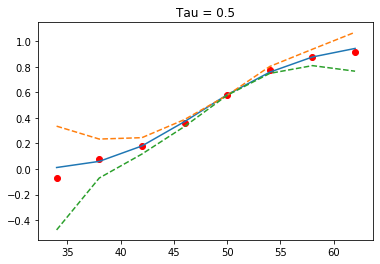

In [62]:
#Extrapolation case

extra_tau = 0.5*np.ones(len(test_stocks))
extra_prices = euro_call(test_stocks,K,extra_tau,r,sigma)
extra_delta = delta_call(test_stocks,K,extra_tau,r,sigma)

x_ = np.vstack((extra_tau,test_stocks)).T
x_extra = tf.Variable(x_,dtype=tf.float64)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape1:
        GPR = tfp.distributions.GaussianProcessRegressionModel(my_kernel, index_points=x_extra,observation_index_points=X_tf,observations = y, mean_fn=mean_f, \
                                            observation_noise_variance=sn2,jitter=1e-06, name='GPR')
        p_hat = GPR.mean()
        K_star = GPR.variance()
        
delta_ = tape1.gradient(p_hat,x_extra)
K_g = tape2.gradient(K_star,x_extra)

lower_bound = delta_[:,1]-z*np.sqrt(np.abs(K_g[:,-1]))
upper_bound = delta_[:,1]+z*np.sqrt(np.abs(K_g[:,-1]))

plt.plot(test_stocks,extra_delta)
plt.title('Tau = 0.5')
plt.scatter(test_stocks,delta_[:,1],color='red')
plt.plot(test_stocks,upper_bound,'--')
plt.plot(test_stocks,lower_bound,'--')
plt.show()